In [4]:
import easydict
from utils import santo, simulate_stitching, evaluation
from data import intersect
import numpy as np
from tqdm import tqdm
import scanpy as sc
import math
import torch

You choose align


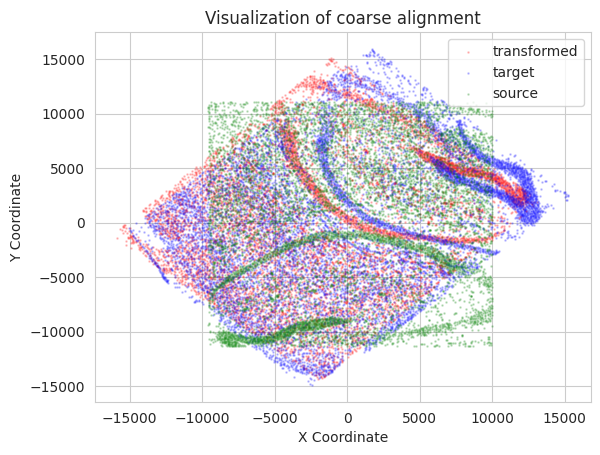

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 19, Loss: 0.22705447673797607: 100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


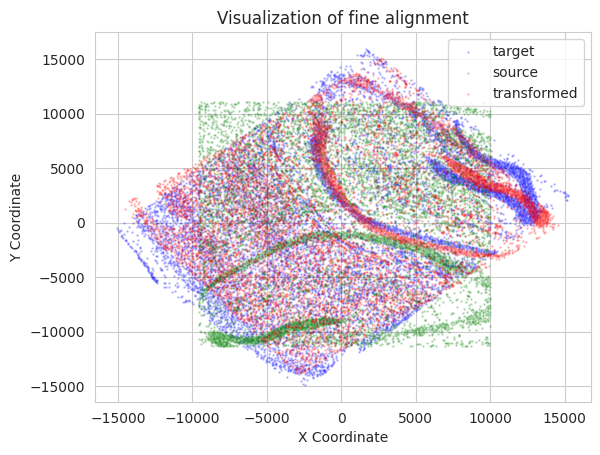

pcc: 0.18778453622064123, ci: 0.38233193920228503


In [8]:
### STARmap PLUS (rotate 45 degree)


train_ad1 = sc.read_h5ad('Dataset/8month_cr1_example_align.h5ad')
train_ad2 = sc.read_h5ad('Dataset/8month_cr2_example_align.h5ad')

src_cor = np.array(train_ad1.obsm['spatial'])
tgt_cor = np.array(train_ad2.obsm['spatial'])
radian = math.radians(45)
rotation = np.array([[ np.cos(radian), -np.sin(radian)],
                     [np.sin(radian),  np.cos(radian)]])

tgt_cor = np.dot(tgt_cor, rotation.T)

train_ad2.obsm['spatial'] = tgt_cor
train_ad1.obsm['spatial'] = src_cor

sc.pp.normalize_total(train_ad1)
sc.pp.normalize_total(train_ad2)

args = easydict.EasyDict({})
args.epochs = 20
args.lr = 0.01
args.k = 5
args.alpha = 0.1 # weight of transcriptional loss
args.diff_omics = False # whether to use different omics data
args.mode = 'align' # Choose the mode among 'align', 'stitch' and None
args.dimension = 2  # choose the dimension of coordinates (2 or 3)
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # choose the device
align_source_cor, trans_dict = santo(train_ad1, train_ad2, args)


#evaluation
pcc,ci = evaluation(align_source_cor,
                   train_ad2.obsm['spatial'],
                   train_ad1.X,
                   train_ad2.X,
                   np.array(train_ad1.obsm['celltype']),
                   np.array(train_ad2.obsm['celltype']))

print(f'pcc: {pcc}, ci: {ci}')

You choose stitch


/home/lih0m/STalign/SANTO_revise/utils.py:335: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  src.obsm['spatial'] = aligned_source


Coarse stitching is finished, there are 105 matched pairs 


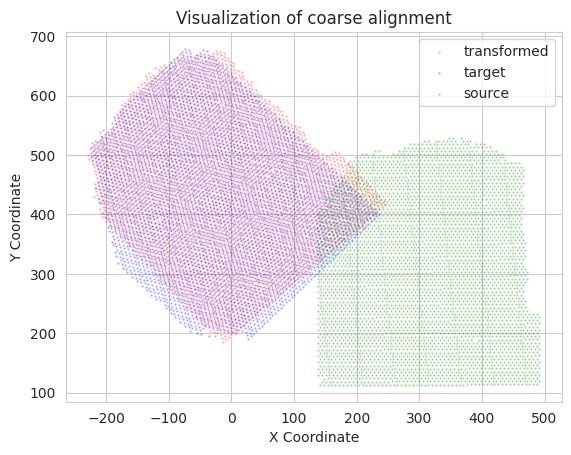

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 19, Loss: 0.028654232621192932: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


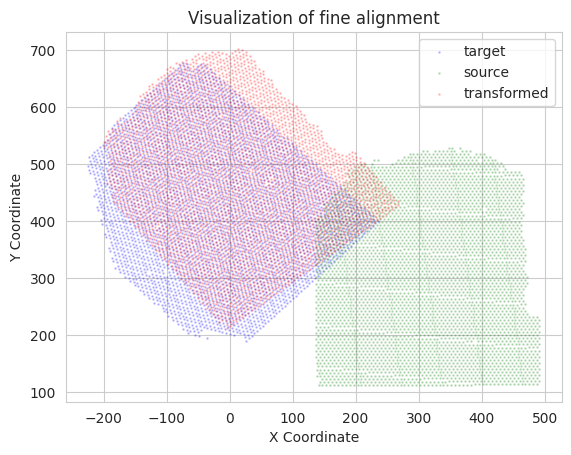

pcc: 0.871527419767959, ci: 0.7081024016891


In [28]:
### DLPFC stitching (rotate 45 degree, 80% overlap)



train_ad1 = sc.read_h5ad('Dataset/151507_preprocessed.h5')
train_ad2 = sc.read_h5ad('Dataset/151508_preprocessed.h5')
train_ad1.X = np.array(train_ad1.X.todense())
train_ad2.X = np.array(train_ad2.X.todense())

adata1 = simulate_stitching(train_ad1, axis=0, from_low=True, threshold=0.1)
adata2 = simulate_stitching(train_ad2, axis=0, from_low=False, threshold=0.1)
train_ad1_part_overlap_index = adata1.obsm['spatial'][:,0] < np.max(adata2.obsm['spatial'][:,0])
train_ad2_part_overlap_index = adata2.obsm['spatial'][:,0] > np.min(adata1.obsm['spatial'][:,0])

src_cor = np.array(adata1.obsm['spatial'])
tgt_cor = np.array(adata2.obsm['spatial'])
radian = math.radians(45)
rotation = np.array([[np.cos(radian), -np.sin(radian)],
                     [np.sin(radian),  np.cos(radian)]])

tgt_cor = np.dot(tgt_cor, rotation.T)
adata1.obsm['spatial'] = src_cor
adata2.obsm['spatial'] = tgt_cor

args = easydict.EasyDict({})
args.epochs = 20
args.lr = 0.001
args.k = 10
args.alpha = 0.9 # weight of transcriptional loss
args.diff_omics = False # whether to use different omics data
args.mode = 'stitch' # Choose the mode among 'align', 'stitch' and None
args.dimension = 2  # choose the dimension of coordinates (2 or 3)
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

align_source_cor,trans_dict = santo(adata1, adata2, args)

adata1.obsm['align_spatial'] = align_source_cor


src_overlap = adata1[train_ad1_part_overlap_index,:]
tgt_overlap = adata2[train_ad2_part_overlap_index,:]
common_genes = intersect(src_overlap.var.index, tgt_overlap.var.index)
src_overlap = src_overlap[:, common_genes]
tgt_overlap = tgt_overlap[:, common_genes]
src_cor = src_overlap.obsm['align_spatial']
tgt_cor = tgt_overlap.obsm['spatial']
src_exp = src_overlap.X
tgt_exp = tgt_overlap.X
src_cell_type = src_overlap.obs['layer_guess'].to_numpy()
tgt_cell_type = tgt_overlap.obs['layer_guess'].to_numpy()

pcc, ci = evaluation(src_cor, tgt_cor, src_exp, tgt_exp, src_cell_type, tgt_cell_type)

print(f'pcc: {pcc}, ci: {ci}')

  0%|          | 0/11 [00:00<?, ?it/s]

No coarse alignment.


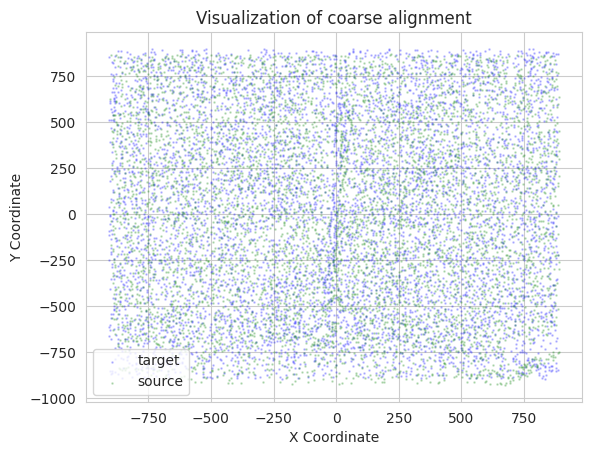

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.23112614452838898: 100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


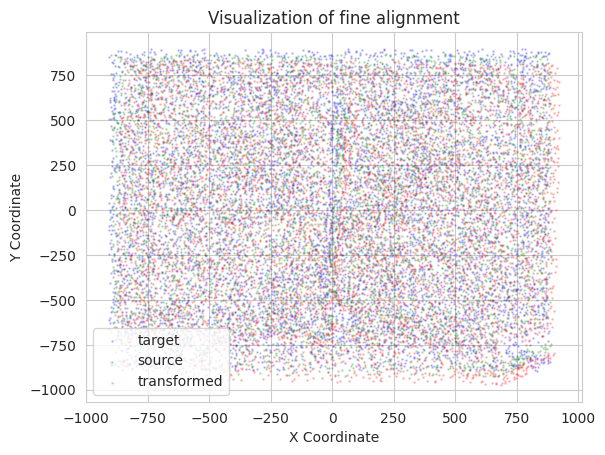

  9%|▉         | 1/11 [01:10<11:48, 70.84s/it]

accuracy: 0.2978018250999124, ci: 0.24237585821491298
No coarse alignment.


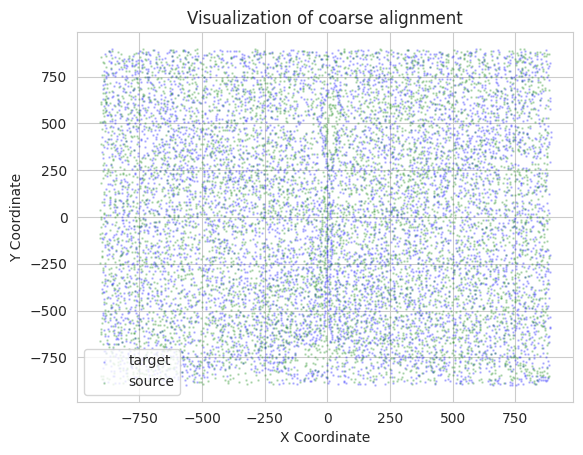

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.23031014204025269: 100%|██████████| 40/40 [01:08<00:00,  1.70s/it]


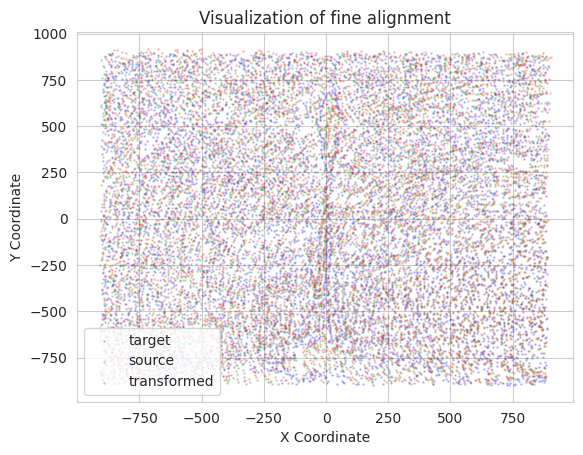

 18%|█▊        | 2/11 [02:22<10:43, 71.49s/it]

accuracy: 0.2802456346039944, ci: 0.24367888748419722
No coarse alignment.


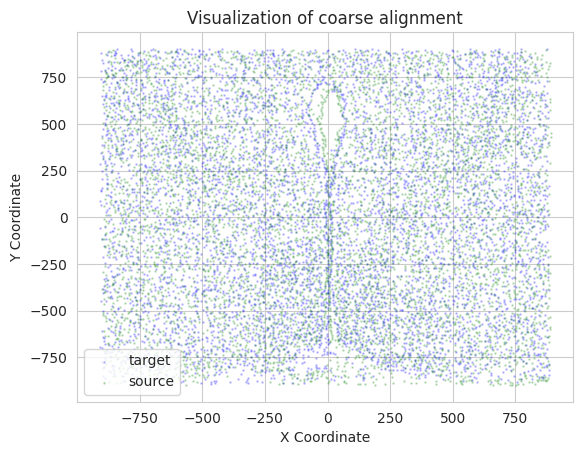

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.22820308804512024: 100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


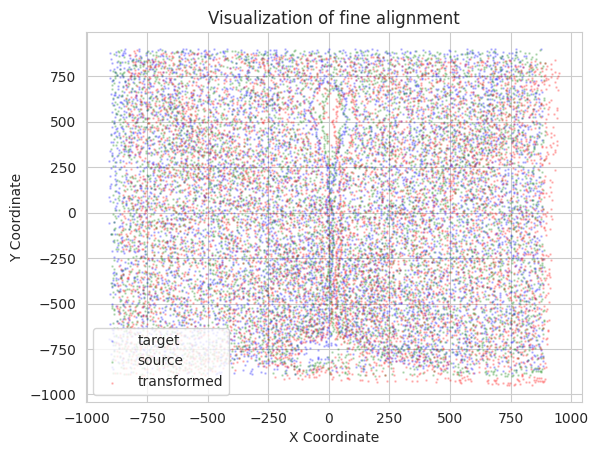

 27%|██▋       | 3/11 [03:34<09:32, 71.50s/it]

accuracy: 0.3333283647313535, ci: 0.31230643846780765
No coarse alignment.


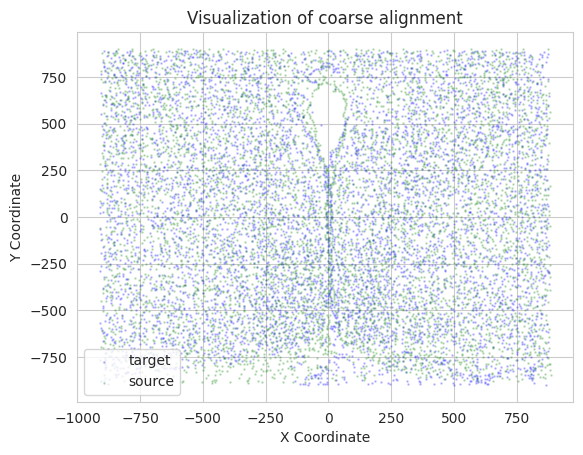

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.22901704907417297: 100%|██████████| 40/40 [01:03<00:00,  1.59s/it]


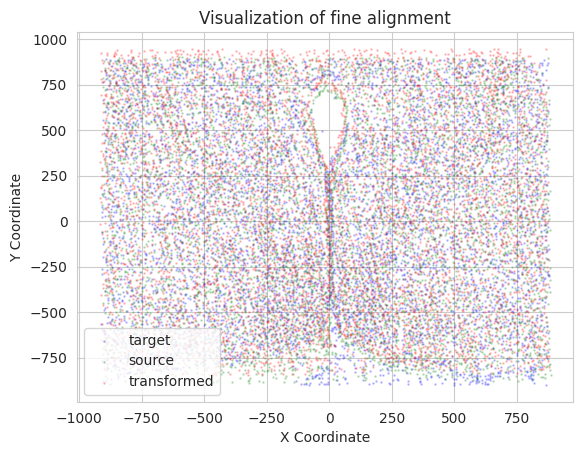

 36%|███▋      | 4/11 [04:41<08:09, 69.92s/it]

accuracy: 0.31888992410445255, ci: 0.27810244070127194
No coarse alignment.


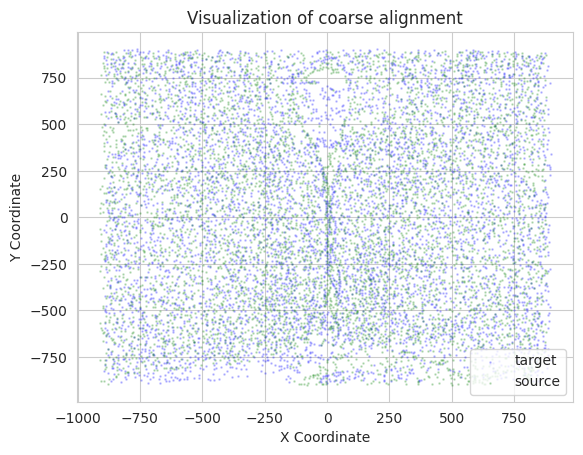

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.23091337084770203: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


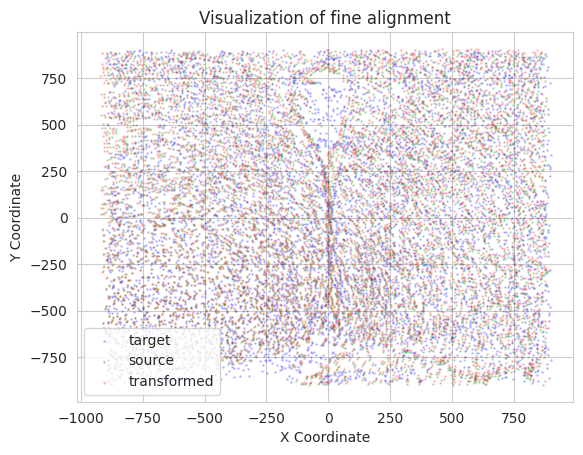

 45%|████▌     | 5/11 [05:47<06:50, 68.40s/it]

accuracy: 0.30301287627238904, ci: 0.26190057965923064
No coarse alignment.


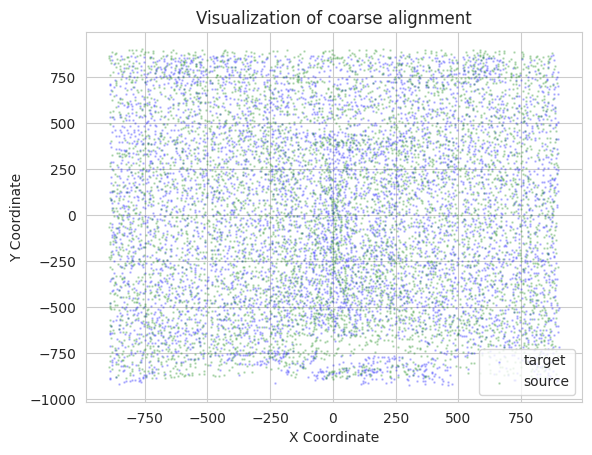

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.2331777662038803: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it]


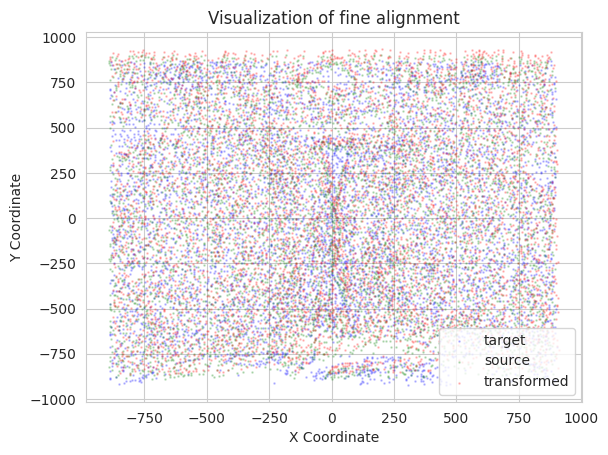

 55%|█████▍    | 6/11 [06:51<05:34, 66.91s/it]

accuracy: 0.2578863000821089, ci: 0.20595489781536294
No coarse alignment.


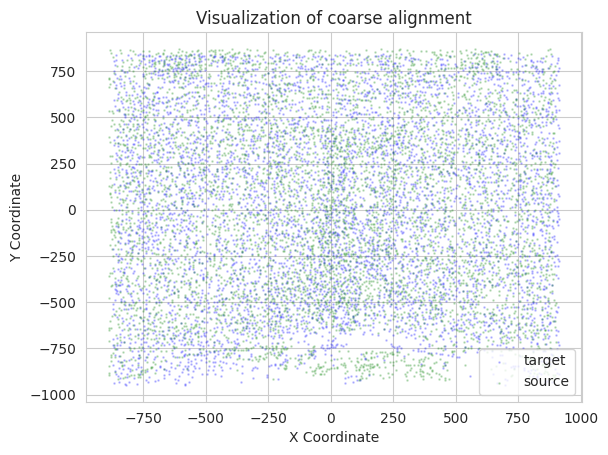

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.23142030835151672: 100%|██████████| 40/40 [00:59<00:00,  1.48s/it]


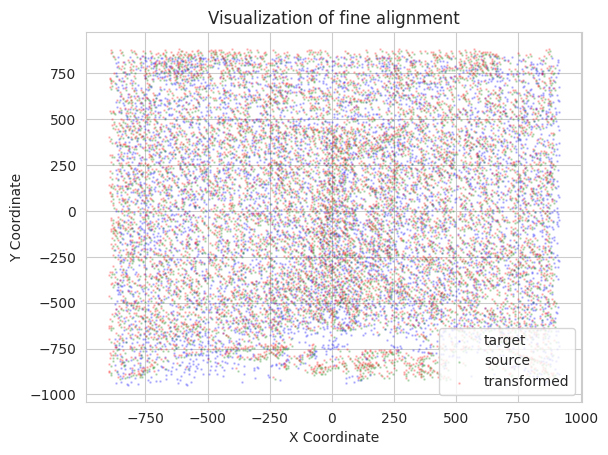

 64%|██████▎   | 7/11 [07:53<04:21, 65.46s/it]

accuracy: 0.2910928053899358, ci: 0.22839620888310722
No coarse alignment.


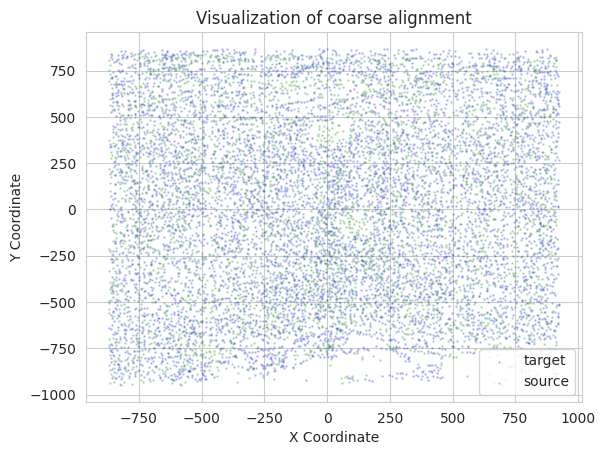

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.2278042435646057: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it]


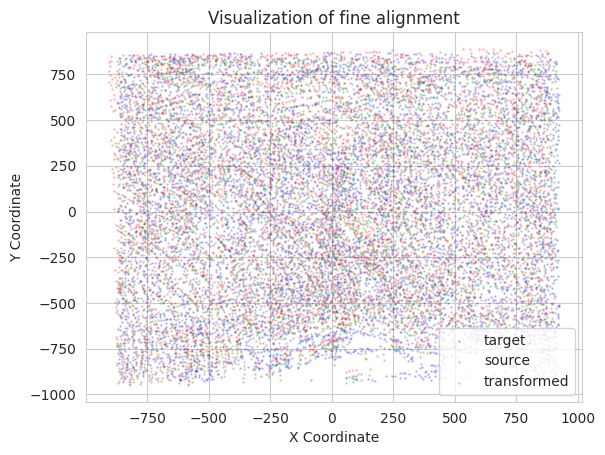

 73%|███████▎  | 8/11 [08:58<03:15, 65.13s/it]

accuracy: 0.33126598527859374, ci: 0.2497380370241006
No coarse alignment.


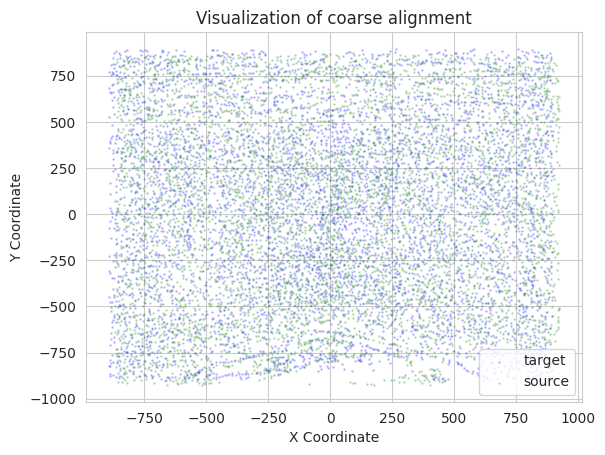

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.22820299863815308: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


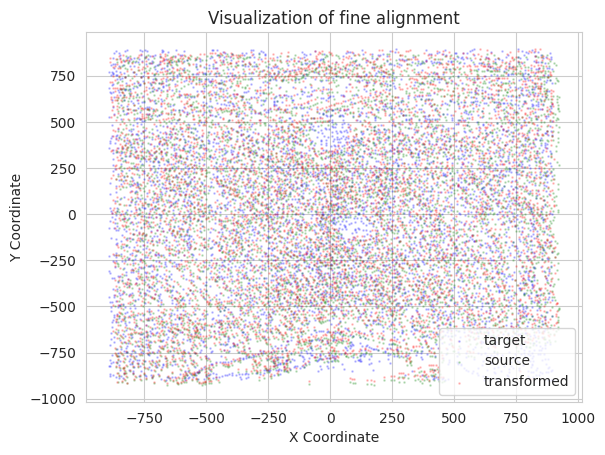

 82%|████████▏ | 9/11 [10:01<02:08, 64.44s/it]

accuracy: 0.34585783657165636, ci: 0.26438304314912947
No coarse alignment.


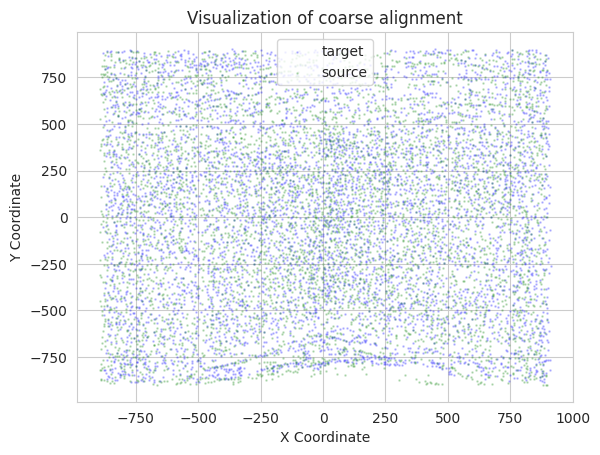

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.22938120365142822: 100%|██████████| 40/40 [00:58<00:00,  1.45s/it]


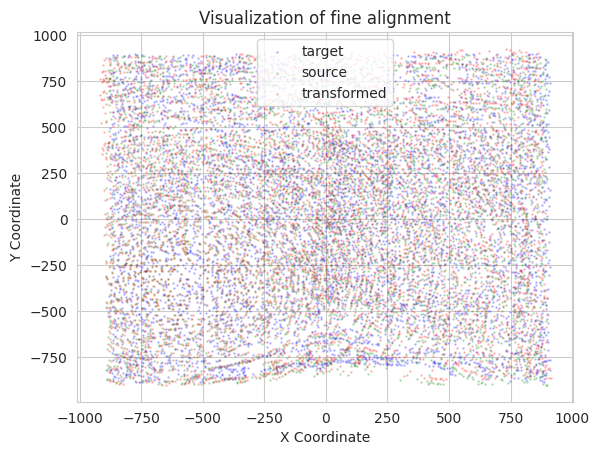

 91%|█████████ | 10/11 [11:02<01:03, 63.53s/it]

accuracy: 0.3116416982183199, ci: 0.2331654542063048
No coarse alignment.


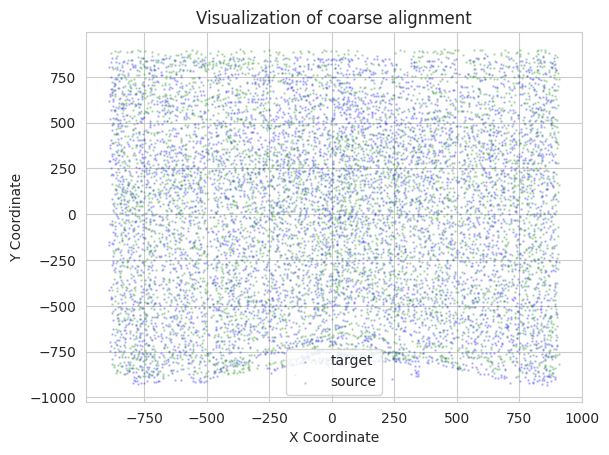

/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(

  0%|          | 0/40 [00:00<?, ?it/s]/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 39, Loss: 0.23081161081790924: 100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


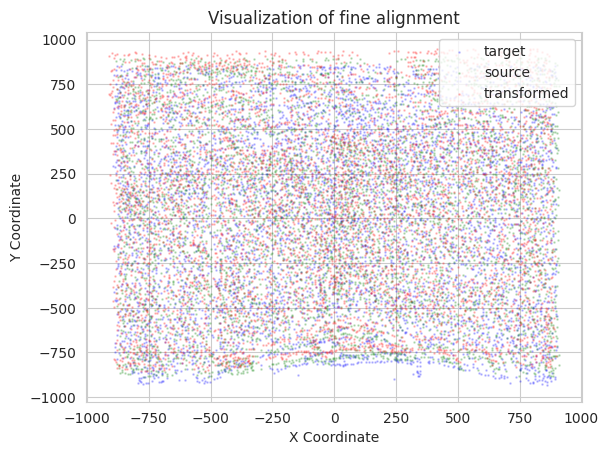

100%|██████████| 11/11 [12:06<00:00, 66.00s/it]

accuracy: 0.3008668490471205, ci: 0.22674749005493464



/home/lih0m/anaconda3/envs/santotest/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


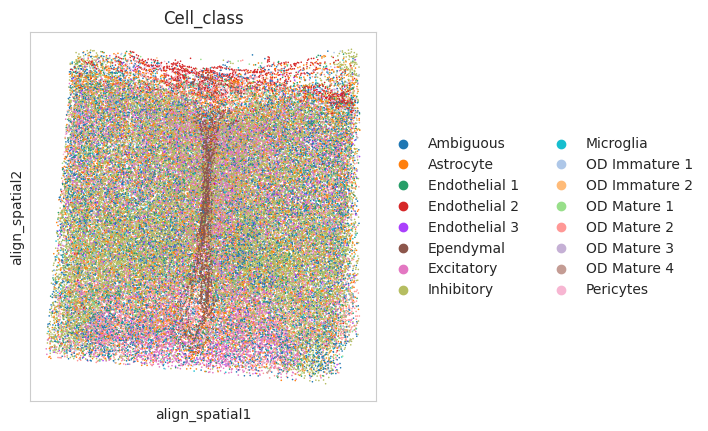

In [51]:
### MERFISH

adata = sc.read_h5ad('Dataset/MERFISH.h5ad')
slice_ids = np.unique(adata.obs.Bregma)
#slice_ids = slice_ids[::-1]
cor = np.array(adata.obsm['spatial'])

args = easydict.EasyDict({})
args.epochs = 40
args.lr = 0.001
args.k = 20
args.alpha = 0.1 # weight of transcriptional loss
args.diff_omics = False # whether to use different omics data
args.mode = 'None' # Choose the mode among 'align', 'stitch' and None
args.dimension = 2  # choose the dimension of coordinates (2 or 3)
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


for id in tqdm(range(len(slice_ids)-1)):
    src = adata[adata.obs.Bregma == slice_ids[id],:].copy()
    tgt = adata[adata.obs.Bregma == slice_ids[id+1],:].copy()

    ### align adjacent slices by SANTO
    aligned_src_cor, trans_dict = santo(src,tgt, args)
    cor[np.isin(adata.obs.Bregma,slice_ids[:id]),:] = np.dot(cor[np.isin(adata.obs.Bregma,slice_ids[:id]),:], trans_dict['fine_R_ab'].T) + trans_dict['fine_T_ab']
    pcc,ci = evaluation(cor[np.isin(adata.obs.Bregma,slice_ids[id]),:],
                         cor[np.isin(adata.obs.Bregma,slice_ids[id+1]),:],
                         src.X,
                         tgt.X,
                         np.array(src.obs.Cell_class),
                         np.array(tgt.obs.Cell_class))
    print(f'accuracy: {pcc}, ci: {ci}')
adata.obsm['align_spatial'] = cor
sc.pl.spatial(adata,color='Cell_class',spot_size=10,basis='align_spatial')
